## Ejercicio banco Mlflow

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import classification_report
# import lime
# import shap
# form lime import lime_tabular

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature 
import seaborn as sns

In [2]:
def saca_metricas(y1, y2):
    print('Matriz de Confusión')
    print(confusion_matrix(y1, y2))
    print('Accuracy:', accuracy_score(y1, y2))
    print('Precision:', precision_score(y1, y2))
    print('Recall:', recall_score(y1, y2))
    print('F1 Score:', f1_score(y1, y2))
    
    # Cálculo de la curva ROC y AUC
    false_positive_rate, recall, _ = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC:', roc_auc)
    
    # Crear gráfico interactivo con Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=false_positive_rate, y=recall, mode='lines', name='Curva ROC', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Línea base', line=dict(color='red', dash='dash')))
    
    fig.update_layout(
        title=f'Curva ROC (AUC = {roc_auc:.2f})',
        xaxis_title='False Positive Rate',
        yaxis_title='Recall',
        template='plotly_white'
    )
    
    fig.show()

In [3]:
df_bank = pd.read_csv('bank-full.csv',sep=';')

In [4]:
categorical_feature = df_bank.select_dtypes(include='object').columns
numerical_feature = df_bank.select_dtypes(exclude='object').columns

In [5]:
for i in categorical_feature:
    le = LabelEncoder()
    df_bank[i] = le.fit_transform(df_bank[i])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df_bank.drop('y',axis=1),
                                                    df_bank['y'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df_bank['y'])

In [7]:
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [8]:
n_estimators = 20
semilla = 42
model1 = RandomForestClassifier(n_estimators=n_estimators)

### Mlflow

MLflow es una librería de código abierto que permite gestionar el ciclo de vida de modelos de machine learning. Sirve para guardar parámetros, métricas y modelos, comparar distintas ejecuciones y organizar experimentos dentro de un mismo proyecto, facilitando la reproducibilidad y el seguimiento de resultados.

Nos permite trabajar varios usuarios en un mismo proyecto.

In [9]:
mlflow.set_experiment('ejercicio_banco_mflow') # Guarda el codigo que vamos a realizar a partir de ahora en ejercicio_banco_mflow, crea una carpeta llamada mlruns

<Experiment: artifact_location='file:///c:/Users/pauri/OneDrive/Escritorio/4%29%20M%C3%81STER%20EN%20DATA%20SCIENCE%2C%20BIG%20DATA%20%26%20BUSINESS%20ANALYTICS%20%28UCM%29/M%C3%93DULO%208_MACHINE%20LEARNING/Clase%205%2C%206%2C%207%20y%208/1.%20Ejercicio_banco/mlruns/267908827470087963', creation_time=1757180975298, experiment_id='267908827470087963', last_update_time=1757180975298, lifecycle_stage='active', name='ejercicio_banco_mflow', tags={}>

In [10]:
mlflow.set_tracking_uri("file:///C:/MLflow/mlruns")  # carpeta corta y simple
mlflow.set_experiment("banco_mflow")

<Experiment: artifact_location='file:///C:/MLflow/mlruns/400025015897031036', creation_time=1757185182849, experiment_id='400025015897031036', last_update_time=1757185182849, lifecycle_stage='active', name='banco_mflow', tags={}>

2025/09/06 21:34:55 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

2025/09/06 21:34:56 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instea

Accuracy: 0.9032400751962845


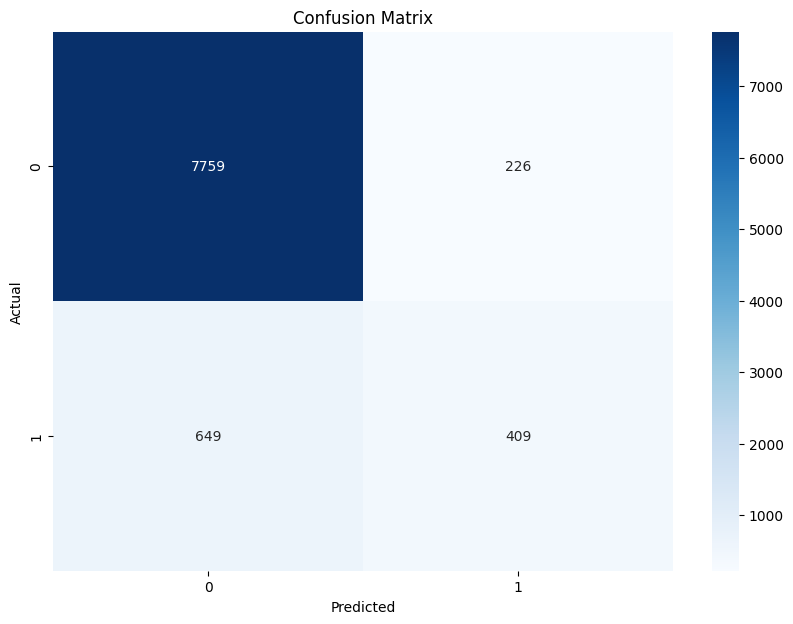

In [11]:
with mlflow.start_run(run_name='rf_model'):
    model1.fit(X_train,y_train)
    y_pred = model1.predict(X_test)

    # Calcular precisión
    accuracy = accuracy_score(y_test,y_pred)

    # Registrar parámetros, métricas y modelo
    mlflow.log_param('random_state',semilla)
    mlflow.log_param('n_estimators',model1.n_estimators)
    mlflow.log_param('max_depth',model1.max_depth)

    mlflow.log_metric('accuracy',accuracy)

    mlflow.sklearn.log_model(model1,'untuned_random_forest')

    # Registrar importancia de las caracteristicas
    feature_importances = model1.feature_importances_
    for i, col in enumerate(X_train.columns):
        mlflow.log_metric(f'importance_{col}',feature_importances[i])
    

    # Guardar conjunto de datos de prueva
    X_test.to_csv('X_test.csv',index=False)
    mlflow.log_artifact('X_test.csv')

    # Crear y guardar matriz de confusión 
    cm = confusion_matrix(y_test,y_pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm,annot=True, fmt='d',cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')


    mlflow.log_artifact('confusion_matrix.png')

    print(f'Accuracy: {accuracy}')




In [ ]:
!mlflow ui # para acceder a mlflow, sino en google localhost:5000

Si hacemos un pequeño cambio/finetuning...

In [13]:
n_estimators = 200
model1 = RandomForestClassifier(n_estimators = n_estimators) 

2025/09/06 21:43:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/09/06 21:43:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Accuracy: 0.905783478933982


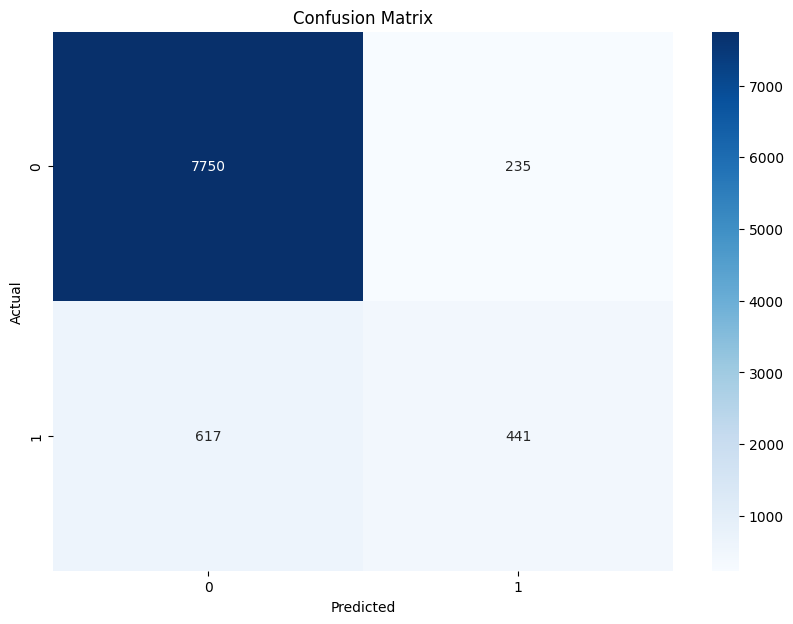

In [14]:
with mlflow.start_run(run_name='tuned_random_forest'):
    model1.fit(X_train, y_train)
    y_pred = model1.predict(X_test)
    
    # Calcular precisión
    accuracy = accuracy_score(y_test, y_pred)
    
    # Registrar parámetros, métricas y modelo
    mlflow.log_param("random_state", semilla)
    mlflow.log_param("n_estimators", model1.n_estimators)
    mlflow.log_param("max_depth", model1.max_depth)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.sklearn.log_model(model1, "tuned_random_forest")
    
    # Registrar importancia de las características
    feature_importances = model1.feature_importances_
    for i, col in enumerate(X_train.columns):
        mlflow.log_metric(f"importance_{col}", feature_importances[i])
    
    # Guardar conjunto de datos de prueba
    X_test.to_csv("X_test.csv", index=False)
    mlflow.log_artifact("X_test.csv")
    
    # Crear y guardar matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    print(f"Accuracy: {accuracy}")

In [ ]:
!mlflow ui # para acceder a mlflow, sino en google localhost:5000